# Random forest su dati epigenomici

In [202]:
import nbimporter
from Import_data import get_df_class, get_df_epigenomic, get_df_sequence , get_type_of_nucl_from_list_of_sequence, convertToNum
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical 
from sklearn.model_selection import train_test_split
sns.set(font_scale=1)
sns.set(color_codes=True)

# RandomForest
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

#BO
from GPyOpt.methods import BayesianOptimization
from numpy.random import seed

#https://stackoverflow.com/questions/51480776/how-to-implement-ratio-based-smote-oversampling-while-cv-ing-dataset
from imblearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

#path
path_relazione = '../../relazione/img/'
path_output = '../output/'

%matplotlib inline

random_state = 42
seed(random_state)
problem = ['A-E','I-E']
line = 'K562'

In [203]:
cell_line = line
path_c = f'../data/classes/{cell_line}_class.csv'
path_e = f'../data/epigenomic-data/{cell_line}.csv'
path_s = f'../data/sequences/{cell_line}.fa'

df_c = get_df_class(path_c)
df_e = get_df_epigenomic(path_e)
df_s = get_df_sequence(path_s)

problem_slug = "_vs_".join(problem)
problem_slug

'A-E_vs_I-E'

In [204]:
df_e.head()

ARID3A  ATF1  ATF3  BACH1  BCLAF1  BDP1  BHLHE40  BRF1  BRF2  \
0    2.99  3.21  0.73   9.56    7.57  0.25     5.41  0.41  0.36   
1    5.17  1.61  0.77   2.44    4.25  0.31    16.69  0.57  0.55   
2    4.48  2.26  0.34   2.66    2.75  0.00     7.47  0.29  0.07   
3    1.48  0.61  0.68   1.87    1.11  0.13     7.70  0.37  0.21   
4    5.24  0.71  0.31  17.19    0.86  0.28     5.27  0.54  0.51   

   BRG1(SMARCA4)  ...   UBTF  USF1  USF2  XRCC4   YY1  ZBTB33  ZBTB7A  ZNF143  \
0           2.45  ...   7.92  9.09  1.68   0.25  6.32    4.49   78.03    2.95   
1           3.85  ...  11.77  3.09  1.02   1.56  2.26    1.33   20.75    5.41   
2           1.37  ...  16.43  7.71  0.58   0.00  2.98    1.21   21.34   12.71   
3           0.90  ...   1.14  7.62  2.41   0.05  0.45    1.58   27.11    3.85   
4           1.97  ...   5.58  5.43  4.47   0.40  1.36    1.21   16.18    4.58   

   ZNF263  ZNF274  
0    4.71    0.00  
1    3.38    0.33  
2    1.15    0.00  
3    4.91    0.04  
4    2.52    0.24  

[5 rows x 135 columns]

In [205]:
# conversione etichette one_hot (si potrebbe fare anche singolo)
type_of_class = sorted(list(df_c['class'].unique()))
lab2int = convertToNum(type_of_class)
classes = np.asarray([  lab2int(el) for el in df_c["class"].values])
print(type_of_class)
classes

['A-E', 'A-P', 'A-X', 'I-E', 'I-P', 'I-X', 'UK']


array([0, 0, 0, ..., 6, 6, 6])

In [206]:
int_labels = [lab2int(el) for el in problem]
int_labels, problem

([0, 3], ['A-E', 'I-E'])

In [207]:
#selezione del problema
X = df_e.values
y = classes
mask = [ el in int_labels for el in classes ]
X,y = X[mask],y[mask]
set(y), len(y)

({0, 3}, 35286)

In [208]:
def _create01mapping(elements):
    d = { k:v for v,k in enumerate(elements)}
    return lambda x : d[x]

label_mapping = _create01mapping(set(y))
y = np.array([ label_mapping(el) for el in y])

# TP è sempre la classe meno numerosa, è il soggetto di interesse
sum(y == 0),len(y==1)
if sum(y==0) < len(y)/2:
    y = 1-y #flipping
y

array([1, 1, 1, ..., 0, 0, 0])

In [209]:
#correct the dimension
X = np.array([ el for el in X])
X.shape

(35286, 135)

In [210]:
randSampler = SMOTE(random_state=random_state)

def resampler(x,y):
    # https://stackoverflow.com/questions/34972142/sklearn-logistic-regression-valueerror-found-array-with-dim-3-estimator-expec
    x, y = randSampler.fit_resample(x, y)
    return x,y


## Cerchiamo un intorno di attributi buoni

In [211]:
n_split = 3

def happy_function(x):
    n_estimators, max_depth, max_features = x[0]
    

    
    conf_matrix = np.zeros([2,2])
    
    skf = StratifiedKFold(n_splits=n_split, random_state=random_state)
    for nth, other in enumerate(skf.split(X,y)):
        train_index, test_index = other
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train_balanced, y_train_balanced = resampler(X_train, y_train)

        rf = RandomForestClassifier(max_features=int(max_features),max_depth=int(max_depth),n_estimators=int(n_estimators), random_state = random_state)
        rf.fit(X_train,y_train)

        y_pred = rf.predict(X_test)
        
        cm = confusion_matrix(y_test, y_pred)
        conf_matrix = conf_matrix + cm
        
    conf_matrix = conf_matrix.astype(int)
    #print(conf_matrix)
    TN, FP, FN, TP = conf_matrix.flatten()
    
    precision = TP / ( 0.00001 if TP + FP == 0 else TP + FP )
    recall = TP / ( 0.00001 if TP + FN == 0 else TP + FN )
    f1_score = 2* (precision*recall)/(precision + recall)
    f1_score = f1_score if not (f1_score is np.nan or f1_score != f1_score) else 0
    accuracy = (TP + TN )/(TP + TN + FP + FN)
    print(f'End with: n_estim:{n_estimators} max_depth:{max_depth} max_feat:{max_features}    (Acc,prec,rec,f1)=({accuracy:.3f},{precision:.3f},{recall:.3f},{f1_score:.3f})')
    return f1_score
    

In [212]:
batch_size = 4
num_cores = 4
max_time = 60*40
max_iter = 40
init_points = 40

domain = [
    {'name': 'n_estimators', 'type': 'discrete', 'domain':list(range(1,201,2))},
    {'name': 'max_depth','type': 'discrete', 'domain': list(range(1,int(math.log2(X.shape[0]))*3,1)) },
    {'name': 'max_features', 'type': 'discrete', 'domain':list(range(1,int(X.shape[1]/2),1)) }
]

In [213]:
myBopt = BayesianOptimization(f=happy_function,
                            domain = domain,
                            maximize=True,
                            normalize_Y = False,
                            model_type="GP",
                            acquisition_type = 'EI',
                            acquisition_jitter= 0.01,#"GP_MCMC",
                            #acquisition_type = "EI",#'EI_MCMC',
                            #evaluator_type = 'predictive',   
                            initial_design_numdata = init_points,
                            batch_size = batch_size,
                            num_cores = num_cores)

myBopt.run_optimization(max_iter=max_iter,max_time=max_time, save_models_parameters=False, verbosity=True)

Process Process-3:
Process Process-4:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


Error in parallel computation. Fall back to single process!


  File "/usr/lib64/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lucavecchi/uni/bioinfo/progetto/venv/lib64/python3.6/site-packages/GPyOpt/util/general.py", line 149, in fun
    pipe.send(f(x))
  File "/home/lucavecchi/uni/bioinfo/progetto/venv/lib64/python3.6/site-packages/GPyOpt/core/task/objective.py", line 74, in _eval_func
    rlt = self.func(np.atleast_2d(x[i]))
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lucavecchi/uni/bioinfo/progetto/venv/lib64/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 201, in f
    def f(x):return -f_copy(x)
  File "/home/lucavecchi/uni/bioinfo/progetto/venv/lib64/python3.6/site-packages/GPyOpt/util/general.py", line 149, in fun
    pipe.send(f(x))
  File "<ipython-input-211-d544

KeyboardInterrupt: 

In [ ]:
myBopt.plot_convergence(filename=f'{path_output}{cell_line}_{problem_slug}_convergence_mpl_epi.pdf')

In [ ]:
def get_grid_random_forest(m_from_opt, num_el):
    n_estimators, max_depth, max_features = m_from_opt.x_opt
    r = [ 2**el for el in range(1,num_el+1)]
    r.extend([-el for el in r]),r.append(0)
    r= sorted(r)
    r = np.array(r)

    return { 'rf__max_depth': [ el for el in r + int(max_depth) if el > 0 ],
     'rf__max_features': [ el for el in r + int(max_features) if el > 0 ],
      'rf__n_estimators': [ el for el in r + int(n_estimators) if el > 0]}


In [ ]:
grid_values = get_grid_random_forest(myBopt,1)
grid_values

In [ ]:
#define some scorer for gridsearch
def accuracy_on_true_pred(y_true,y_pred, **kwargs):
    acc = np.sum(y_true==y_pred)/len(y_true)
    print(f'Acc: {acc}')
    return acc

def f1_score_on_true_pred(y_true, y_pred, **kwargs):
    TN, FP, FN, TP  = confusion_matrix(y_true, y_pred).astype(int).flatten()

    #caso quando tp + fp o fn + tp sono 0 
    precision = TP / ( 0.00001 if TP + FP == 0 else TP + FP )
    recall = TP / ( 0.00001 if TP + FN == 0 else TP + FN )
    f1_score = 2* (precision*recall)/(precision + recall)
    f1_score = f1_score if not (f1_score is np.nan or f1_score != f1_score) else 0
    return f1_score

accuracy_scorer = make_scorer(accuracy_on_true_pred, greater_is_better=True, needs_proba=False,needs_threshold=False)
f1_scorer = make_scorer(f1_score_on_true_pred, greater_is_better=True, needs_proba=False, needs_threshold=False)

In [ ]:
rf = RandomForestClassifier(random_state=42)
pipeline = Pipeline([
    ('oversampling',RandomOverSampler(random_state=random_state))
    ,('rf',rf)
])

clf = GridSearchCV(pipeline
                   ,grid_values
                   ,scoring = f1_scorer
                   ,cv = 4
                   ,n_jobs=-1
                   ,pre_dispatch='3*n_jobs'
                   ,verbose=2)
clf.fit(X,y)

In [22]:
df_result = pd.DataFrame(clf.cv_results_)
df_result = df_result.sort_values(['rank_test_score','std_test_score'],ascending=[1,1])
df_result.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0     369.473124      8.146057          0.36605        0.110791   

  param_rf__criterion param_rf__max_depth param_rf__max_features  \
0                gini                  40                     22   

  param_rf__n_estimators                                             params  \
0                    199  {'rf__criterion': 'gini', 'rf__max_depth': 40,...   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0            0.89886            0.89338           0.880235           0.908163   

   mean_test_score  std_test_score  rank_test_score  
0          0.89516        0.010108                1

## Analisi migliore classificatore trovato ROC & PRC

In [214]:
#np.save(f'{path_output}{cell_line}_{problem_slug}_best_param_rf_epi',df_result.iloc[0].to_dict())
# recover if there are some problem https://stackoverflow.com/questions/8361561/recover-dict-from-0-d-numpy-array
df_best_result = np.load(f'{path_output}{cell_line}_{problem_slug}_best_param_rf_epi.npy', allow_pickle=True)
df_best_result = df_best_result.item()

In [153]:
df_best_result = df_result.iloc[0].to_dict()
df_best_result

NameError: name 'df_result' is not defined

## Statistiche

In [215]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report,precision_recall_curve,average_precision_score,f1_score
from joblib import dump, load
from itertools import chain

test_pred_arr = []
best_rf =  None
skf = StratifiedKFold(n_splits=n_split, random_state=random_state)
for nth, other in enumerate(skf.split(X,y)):
    train_index, test_index = other
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_balanced, y_train_balanced = resampler(X_train, y_train)

    _best_rf = RandomForestClassifier(max_depth=df_best_result['param_rf__max_depth'], max_features=df_best_result['param_rf__max_features'], n_estimators=df_best_result['param_rf__n_estimators'])
    _best_rf.fit(X_train,y_train)

    y_pred = _best_rf.predict_proba(X_test)
    
    test_pred_arr.append((y_test,y_pred,nth))
    best_rf = _best_rf


### Raccolta dei risultati


In [216]:
result = {'ROC':{},'PRC':{}}

In [217]:
tpr, fpr, threshold = roc_curve(np.concatenate([el[0] for el in test_pred_arr]), np.array(list(chain(*[[ pair[0] for pair in el[1]] for el in test_pred_arr]))))
auc = roc_auc_score(np.concatenate([el[0] for el in test_pred_arr]), np.array(list(chain(*[[ pair[1] for pair in el[1]] for el in test_pred_arr]))))
plt.figure()
plt.plot(fpr,tpr,color='darkorange', label=f'RF mean AUC:{auc:.3f}')

for y_t, y_prob_pair, nth in test_pred_arr:
    _tpr,_fpr,_threshold = roc_curve(y_t,[pair[0] for pair in y_prob_pair])
    _auc = roc_auc_score(y_t, [pair[1] for pair in y_prob_pair])
    plt.plot(_fpr,_tpr,label=f'{nth+1}°-fold AUC:{_auc:.3f}')
    
    result["ROC"][nth] = {_auc}

result["ROC"]['tot'] = {auc} 

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='br')
plt.savefig(path_relazione + f'{cell_line}_{problem_slug}_best_AUC_ROC_rf_epi.pdf')
plt.show()

In [218]:
p, r, thr = precision_recall_curve(np.concatenate([el[0] for el in test_pred_arr]), np.array(list(chain(*[[ pair[1] for pair in el[1]] for el in test_pred_arr]))))
aucprc = average_precision_score(np.concatenate([el[0] for el in test_pred_arr]), np.array(list(chain(*[[ pair[1] for pair in el[1]] for el in test_pred_arr]))))
f1_score_arr = 2*p*r/(p+r)
best_threshold = thr[f1_score_arr.argmax()]
f1 = f1_score(np.concatenate([el[0] for el in test_pred_arr]), np.array(list(chain(*[[ pair[1] for pair in el[1]] for el in test_pred_arr])))>best_threshold)

plt.figure()

plt.plot(p,r,color='darkorange', label=f'RF mean AUC:{aucprc:.3f} f1:{f1:.3f}')
    
for y_t, y_prob_pair, nth in test_pred_arr:
    _p,_r,_thr = precision_recall_curve(y_t,[pair[1] for pair in y_prob_pair])
    _f1_score_arr = 2*_p*_r/(_p+_r)
    _best_threshold = _thr[_f1_score_arr.argmax()]
    _f1 = f1_score(y_t, [pair[1] for pair in y_prob_pair]>_best_threshold)
    _auc = average_precision_score(y_t, [pair[1] for pair in y_prob_pair])
    plt.plot(_p,_r,label=f'{nth+1}°-fold AUC:{_auc:.3f} f1:{_f1:.3f}')

    result["PRC"][nth]= [_auc,_f1]
    
result["PRC"]['tot']= [aucprc,f1]

plt.title(f'Best threshold {best_threshold:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='br')
plt.savefig(path_relazione + f'{cell_line}_{problem_slug}_best_AUC_PRC_rf_epi.pdf')
plt.show()

In [219]:
dump(result, f'{path_output}{cell_line}_{problem_slug}_best_result_rf_epi.joblib') 
result

{'ROC': {0: {0.9651626100029506},
  1: {0.9634765615852603},
  2: {0.960546027950936},
  'tot': {0.9629014382409311}},
 'PRC': {0: [0.8711044406311742, 0.8652482269503546],
  1: [0.8753071627641339, 0.8525179856115108],
  2: [0.8552573630311485, 0.8351648351648351],
  'tot': [0.8656390184155762, 0.847247990105133]}}

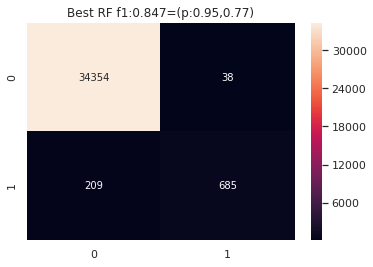

In [220]:
plotted = sns.heatmap(confusion_matrix(np.concatenate([el[0] for el in test_pred_arr]), np.array(list(chain(*[[ pair[1] for pair in el[1]] for el in test_pred_arr])))>best_threshold) ,annot=True,fmt="d").set_title(f'Best RF f1:{f1:.3f}=(p:{p[f1_score_arr.argmax()]:.2f},{r[f1_score_arr.argmax()]:.2f})')
fig = plotted.get_figure()
fig.savefig(path_relazione + f'{cell_line}_{problem_slug}_best_confusion_rf_epi.pdf')

## Analisi dell'importanza delle feature

In [221]:
thr = 0.25
importances = best_rf.feature_importances_

indices = np.argsort(importances)[::-1]
trim_pos = int(len(indices)*thr)
indices = indices[0:trim_pos]

name = df_e.columns[indices]
df = pd.DataFrame({'feature':name,
             'importance':importances[indices]})
df.head()

feature  importance
0     TAF1    0.339345
1     PHF8    0.113421
2      TBP    0.099145
3  H3K27AC    0.066520
4   H3K9AC    0.045756

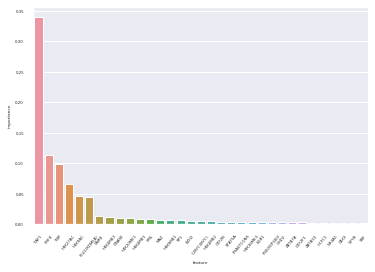

In [222]:
sns.set(font_scale=0.35)
plotted = sns.barplot(x='feature',y='importance',data=df)
plotted.set_xticklabels(plotted.get_xticklabels(),rotation=50)
plotted.get_figure().savefig(f'{path_relazione}{cell_line}_{problem_slug}_importance_rank_rf_epi.pdf')